<a href="https://colab.research.google.com/github/Ssurf777/U-Net_pipe_flow/blob/main/U_net_pipe_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CFD datasets import

In [1]:
import numpy as np
import requests

url = 'https://github.com/Ssurf777/U-Net_pipe_flow/raw/main/data/cfd_data.npy'
r = requests.get(url)

with open('cfd_data.npy', 'wb') as f:
  f.write(r.content)

data = np.load('cfd_data.npy')
data.shape


(163390, 7)

# Visualization datasets

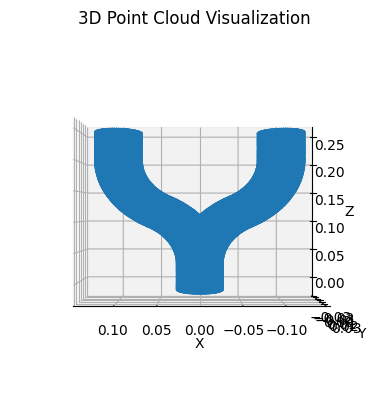

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract x, y, and z columns
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=1)  # s controls the size of the points

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud Visualization')

# Set the view angle to look from the positive y-axis
ax.view_init(elev=0, azim=90) # elev is elevation, azim is azimuthal angle

plt.show()


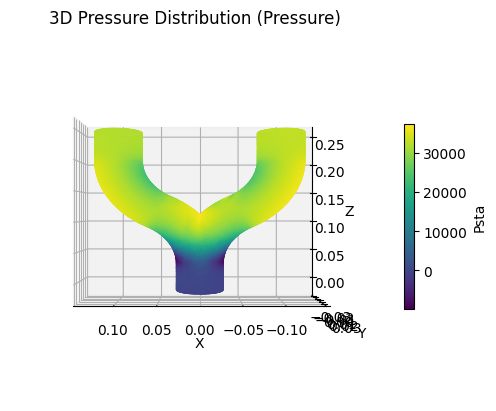

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 6]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Psta')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Pressure)')
ax.view_init(elev=0, azim=90)

plt.show()


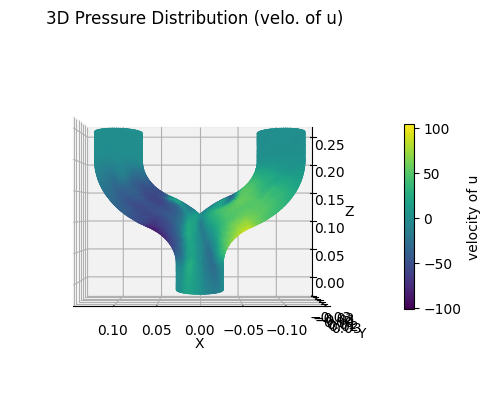

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 3]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('velocity of u')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (velo. of u)')
ax.view_init(elev=0, azim=90)

plt.show()


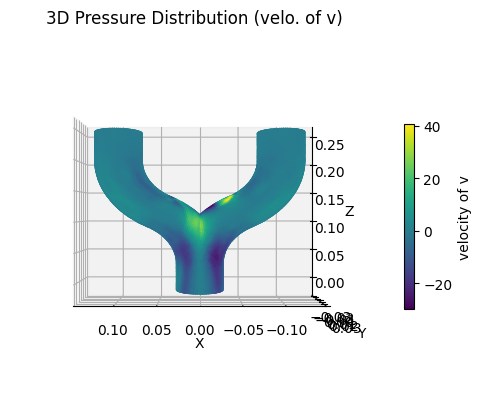

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 4]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('velocity of v')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (velo. of v)')
ax.view_init(elev=0, azim=90)

plt.show()


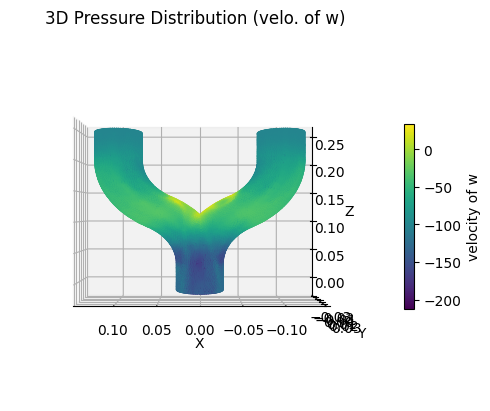

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 5]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('velocity of w')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (velo. of w)')
ax.view_init(elev=0, azim=90)

plt.show()


# U-Net define

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def mish(x):
    return x * torch.tanh(F.softplus(x))

def init_weights_kaiming(module):
    if isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')  # Mish用のHeもrelu指定で問題なし
        if module.bias is not None:
            nn.init.zeros_(module.bias)

class PointNetEncoder(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.apply(init_weights_kaiming)

    def forward(self, x):
        x = x.transpose(1, 2)        # [B, 3, N]
        x1 = mish(self.conv1(x))     # [B, 64, N]
        x2 = mish(self.conv2(x1))    # [B, 128, N]
        x3 = mish(self.conv3(x2))    # [B, 256, N]
        return x1, x2, x3

class PointNetDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv1 = nn.Conv1d(256 + 128, 128, 1)
        self.upconv2 = nn.Conv1d(128 + 64, 64, 1)
        self.out = nn.Conv1d(64, 4, 1)
        self.apply(init_weights_kaiming)

    def forward(self, x1, x2, x3):
        up1 = mish(self.upconv1(torch.cat([x3, x2], dim=1)))  # [B, 128, N]
        up2 = mish(self.upconv2(torch.cat([up1, x1], dim=1))) # [B, 64, N]
        out = self.out(up2)                                   # [B, 4, N]
        return out.transpose(1, 2)                            # [B, N, 4]

class PointUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = PointNetEncoder()
        self.decoder = PointNetDecoder()

    def forward(self, x):  # x: [B, N, 3]
        x1, x2, x3 = self.encoder(x)
        out = self.decoder(x1, x2, x3)
        return out  # [B, N, 4]


# dataloader

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CFDDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        data = np.load(data_path)  # shape: (N, 7)
        self.inputs = data[:, 0:3].astype(np.float32)  # x, y, z
        #self.targets = data[:, 3:7].astype(np.float32)  # u, v, w, p
        self.targets = data[:, 6].astype(np.float32)  # p

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [9]:
class CFDPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, n_points=1024):
        data = np.load(data_path).astype(np.float32)  # shape: [N_total, 7]
        self.n_points = n_points
        self.inputs = data[:, 0:3]
        self.raw_targets = data[:, 6]

        self.p_min = self.raw_targets.min()
        self.p_max = self.raw_targets.max()
        self.targets = (self.raw_targets - self.p_min) / (self.p_max - self.p_min)

        total_points = len(self.inputs)
        total_groups = total_points // n_points
        self.inputs = self.inputs[:total_groups * n_points].reshape(total_groups, n_points, 3)
        self.targets = self.targets[:total_groups * n_points].reshape(total_groups, n_points, 1)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def inverse_transform(self, norm_p):
        return norm_p * (self.p_max - self.p_min) + self.p_min


In [10]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CFDDataset2(Dataset):
    def __init__(self, data_path):
        super().__init__()
        data = np.load(data_path).astype(np.float32)  # shape: (N, 7)
        self.inputs = data[:, 0:3]    # x, y, z
        self.raw_targets = data[:, 6] # p

        # --- Min-Max Scaling ---
        self.p_min = self.raw_targets.min()
        self.p_max = self.raw_targets.max()
        self.targets = (self.raw_targets - self.p_min) / (self.p_max - self.p_min)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def inverse_transform(self, norm_p):
        """正規化されたpを元のスケールに戻す"""
        return norm_p * (self.p_max - self.p_min) + self.p_min


In [11]:
# データ読み込み
train_dataset = CFDPointCloudDataset('cfd_data.npy')
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False, drop_last=False)

# note
独立点群のため、今後はk-meansなどで近距離点群を集めてバッチ化して学習できるようにすること

# Trainer

In [12]:
from torch import nn, optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 1]

        optimizer.zero_grad()
        outputs = model(batch_inputs)             # [B, N, 4]
        loss = criterion(outputs[:, :, 3:], batch_targets)  # 4番目の出力をMSE対象に
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss / len(train_loader):.6f}")


Epoch 1/200: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Epoch 1 - Loss: 0.724666


Epoch 2/200: 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Epoch 2 - Loss: 0.695562


Epoch 3/200: 100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


Epoch 3 - Loss: 0.667284


Epoch 4/200: 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


Epoch 4 - Loss: 0.639822


Epoch 5/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 5 - Loss: 0.613162


Epoch 6/200: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 6 - Loss: 0.587286


Epoch 7/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 7 - Loss: 0.562174


Epoch 8/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 8 - Loss: 0.537804


Epoch 9/200: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Epoch 9 - Loss: 0.514155


Epoch 10/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 10 - Loss: 0.491206


Epoch 11/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 11 - Loss: 0.468936


Epoch 12/200: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Epoch 12 - Loss: 0.447325


Epoch 13/200: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Epoch 13 - Loss: 0.426355


Epoch 14/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 14 - Loss: 0.406007


Epoch 15/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 15 - Loss: 0.386264


Epoch 16/200: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 16 - Loss: 0.367111


Epoch 17/200: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Epoch 17 - Loss: 0.348535


Epoch 18/200: 100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


Epoch 18 - Loss: 0.330524


Epoch 19/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 19 - Loss: 0.313069


Epoch 20/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 20 - Loss: 0.296159


Epoch 21/200: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


Epoch 21 - Loss: 0.279789


Epoch 22/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 22 - Loss: 0.263954


Epoch 23/200: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 23 - Loss: 0.248649


Epoch 24/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 24 - Loss: 0.233873


Epoch 25/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 25 - Loss: 0.219624


Epoch 26/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 26 - Loss: 0.205904


Epoch 27/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 27 - Loss: 0.192713


Epoch 28/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 28 - Loss: 0.180056


Epoch 29/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 29 - Loss: 0.167935


Epoch 30/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 30 - Loss: 0.156355


Epoch 31/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 31 - Loss: 0.145321


Epoch 32/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 32 - Loss: 0.134837


Epoch 33/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 33 - Loss: 0.124909


Epoch 34/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 34 - Loss: 0.115541


Epoch 35/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 35 - Loss: 0.106738


Epoch 36/200: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 36 - Loss: 0.098503


Epoch 37/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 37 - Loss: 0.090837


Epoch 38/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 38 - Loss: 0.083741


Epoch 39/200: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Epoch 39 - Loss: 0.077214


Epoch 40/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 40 - Loss: 0.071251


Epoch 41/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 41 - Loss: 0.065846


Epoch 42/200: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Epoch 42 - Loss: 0.060989


Epoch 43/200: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Epoch 43 - Loss: 0.056668


Epoch 44/200: 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


Epoch 44 - Loss: 0.052866


Epoch 45/200: 100%|██████████| 1/1 [00:00<00:00, 11.80it/s]


Epoch 45 - Loss: 0.049564


Epoch 46/200: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


Epoch 46 - Loss: 0.046737


Epoch 47/200: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


Epoch 47 - Loss: 0.044360


Epoch 48/200: 100%|██████████| 1/1 [00:00<00:00, 12.51it/s]


Epoch 48 - Loss: 0.042401


Epoch 49/200: 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


Epoch 49 - Loss: 0.040827


Epoch 50/200: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


Epoch 50 - Loss: 0.039601


Epoch 51/200: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


Epoch 51 - Loss: 0.038684


Epoch 52/200: 100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


Epoch 52 - Loss: 0.038035


Epoch 53/200: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


Epoch 53 - Loss: 0.037614


Epoch 54/200: 100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


Epoch 54 - Loss: 0.037380


Epoch 55/200: 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


Epoch 55 - Loss: 0.037293


Epoch 56/200: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


Epoch 56 - Loss: 0.037315


Epoch 57/200: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


Epoch 57 - Loss: 0.037410


Epoch 58/200: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Epoch 58 - Loss: 0.037548


Epoch 59/200: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


Epoch 59 - Loss: 0.037700


Epoch 60/200: 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]


Epoch 60 - Loss: 0.037845


Epoch 61/200: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]


Epoch 61 - Loss: 0.037964


Epoch 62/200: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


Epoch 62 - Loss: 0.038043


Epoch 63/200: 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


Epoch 63 - Loss: 0.038075


Epoch 64/200: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


Epoch 64 - Loss: 0.038054


Epoch 65/200: 100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Epoch 65 - Loss: 0.037979


Epoch 66/200: 100%|██████████| 1/1 [00:00<00:00, 10.21it/s]


Epoch 66 - Loss: 0.037853


Epoch 67/200: 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


Epoch 67 - Loss: 0.037680


Epoch 68/200: 100%|██████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 68 - Loss: 0.037465


Epoch 69/200: 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


Epoch 69 - Loss: 0.037218


Epoch 70/200: 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


Epoch 70 - Loss: 0.036945


Epoch 71/200: 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


Epoch 71 - Loss: 0.036654


Epoch 72/200: 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


Epoch 72 - Loss: 0.036354


Epoch 73/200: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Epoch 73 - Loss: 0.036050


Epoch 74/200: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


Epoch 74 - Loss: 0.035750


Epoch 75/200: 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 75 - Loss: 0.035458


Epoch 76/200: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


Epoch 76 - Loss: 0.035178


Epoch 77/200: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


Epoch 77 - Loss: 0.034914


Epoch 78/200: 100%|██████████| 1/1 [00:00<00:00, 12.05it/s]


Epoch 78 - Loss: 0.034667


Epoch 79/200: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


Epoch 79 - Loss: 0.034437


Epoch 80/200: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Epoch 80 - Loss: 0.034226


Epoch 81/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 81 - Loss: 0.034033


Epoch 82/200: 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]


Epoch 82 - Loss: 0.033857


Epoch 83/200: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


Epoch 83 - Loss: 0.033695


Epoch 84/200: 100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


Epoch 84 - Loss: 0.033547


Epoch 85/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 85 - Loss: 0.033411


Epoch 86/200: 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]


Epoch 86 - Loss: 0.033284


Epoch 87/200: 100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


Epoch 87 - Loss: 0.033164


Epoch 88/200: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


Epoch 88 - Loss: 0.033050


Epoch 89/200: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


Epoch 89 - Loss: 0.032941


Epoch 90/200: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


Epoch 90 - Loss: 0.032834


Epoch 91/200: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Epoch 91 - Loss: 0.032728


Epoch 92/200: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


Epoch 92 - Loss: 0.032622


Epoch 93/200: 100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


Epoch 93 - Loss: 0.032516


Epoch 94/200: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


Epoch 94 - Loss: 0.032408


Epoch 95/200: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


Epoch 95 - Loss: 0.032299


Epoch 96/200: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]


Epoch 96 - Loss: 0.032187


Epoch 97/200: 100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


Epoch 97 - Loss: 0.032074


Epoch 98/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 98 - Loss: 0.031959


Epoch 99/200: 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


Epoch 99 - Loss: 0.031843


Epoch 100/200: 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]


Epoch 100 - Loss: 0.031724


Epoch 101/200: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


Epoch 101 - Loss: 0.031605


Epoch 102/200: 100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


Epoch 102 - Loss: 0.031485


Epoch 103/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 103 - Loss: 0.031364


Epoch 104/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 104 - Loss: 0.031243


Epoch 105/200: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


Epoch 105 - Loss: 0.031122


Epoch 106/200: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Epoch 106 - Loss: 0.031001


Epoch 107/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 107 - Loss: 0.030881


Epoch 108/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 108 - Loss: 0.030762


Epoch 109/200: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


Epoch 109 - Loss: 0.030644


Epoch 110/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 110 - Loss: 0.030526


Epoch 111/200: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Epoch 111 - Loss: 0.030410


Epoch 112/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 112 - Loss: 0.030294


Epoch 113/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 113 - Loss: 0.030180


Epoch 114/200: 100%|██████████| 1/1 [00:00<00:00, 12.14it/s]


Epoch 114 - Loss: 0.030067


Epoch 115/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 115 - Loss: 0.029954


Epoch 116/200: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Epoch 116 - Loss: 0.029843


Epoch 117/200: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


Epoch 117 - Loss: 0.029732


Epoch 118/200: 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


Epoch 118 - Loss: 0.029622


Epoch 119/200: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


Epoch 119 - Loss: 0.029512


Epoch 120/200: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


Epoch 120 - Loss: 0.029403


Epoch 121/200: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Epoch 121 - Loss: 0.029294


Epoch 122/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 122 - Loss: 0.029186


Epoch 123/200: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Epoch 123 - Loss: 0.029078


Epoch 124/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 124 - Loss: 0.028970


Epoch 125/200: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Epoch 125 - Loss: 0.028863


Epoch 126/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 126 - Loss: 0.028756


Epoch 127/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 127 - Loss: 0.028649


Epoch 128/200: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Epoch 128 - Loss: 0.028542


Epoch 129/200: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 129 - Loss: 0.028435


Epoch 130/200: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Epoch 130 - Loss: 0.028329


Epoch 131/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 131 - Loss: 0.028223


Epoch 132/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 132 - Loss: 0.028118


Epoch 133/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 133 - Loss: 0.028012


Epoch 134/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 134 - Loss: 0.027907


Epoch 135/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 135 - Loss: 0.027803


Epoch 136/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 136 - Loss: 0.027698


Epoch 137/200: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Epoch 137 - Loss: 0.027595


Epoch 138/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 138 - Loss: 0.027491


Epoch 139/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 139 - Loss: 0.027388


Epoch 140/200: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Epoch 140 - Loss: 0.027286


Epoch 141/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 141 - Loss: 0.027183


Epoch 142/200: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Epoch 142 - Loss: 0.027082


Epoch 143/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 143 - Loss: 0.026980


Epoch 144/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 144 - Loss: 0.026879


Epoch 145/200: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


Epoch 145 - Loss: 0.026779


Epoch 146/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 146 - Loss: 0.026679


Epoch 147/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 147 - Loss: 0.026579


Epoch 148/200: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Epoch 148 - Loss: 0.026480


Epoch 149/200: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Epoch 149 - Loss: 0.026381


Epoch 150/200: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Epoch 150 - Loss: 0.026283


Epoch 151/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 151 - Loss: 0.026185


Epoch 152/200: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Epoch 152 - Loss: 0.026087


Epoch 153/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 153 - Loss: 0.025990


Epoch 154/200: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Epoch 154 - Loss: 0.025893


Epoch 155/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 155 - Loss: 0.025796


Epoch 156/200: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


Epoch 156 - Loss: 0.025700


Epoch 157/200: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]


Epoch 157 - Loss: 0.025605


Epoch 158/200: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


Epoch 158 - Loss: 0.025509


Epoch 159/200: 100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


Epoch 159 - Loss: 0.025414


Epoch 160/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 160 - Loss: 0.025320


Epoch 161/200: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


Epoch 161 - Loss: 0.025226


Epoch 162/200: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


Epoch 162 - Loss: 0.025132


Epoch 163/200: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 163 - Loss: 0.025039


Epoch 164/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 164 - Loss: 0.024946


Epoch 165/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 165 - Loss: 0.024854


Epoch 166/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 166 - Loss: 0.024761


Epoch 167/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 167 - Loss: 0.024670


Epoch 168/200: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Epoch 168 - Loss: 0.024579


Epoch 169/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 169 - Loss: 0.024488


Epoch 170/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 170 - Loss: 0.024397


Epoch 171/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 171 - Loss: 0.024307


Epoch 172/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 172 - Loss: 0.024218


Epoch 173/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 173 - Loss: 0.024128


Epoch 174/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 174 - Loss: 0.024040


Epoch 175/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 175 - Loss: 0.023951


Epoch 176/200: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 176 - Loss: 0.023863


Epoch 177/200: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 177 - Loss: 0.023776


Epoch 178/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 178 - Loss: 0.023688


Epoch 179/200: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


Epoch 179 - Loss: 0.023602


Epoch 180/200: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


Epoch 180 - Loss: 0.023515


Epoch 181/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 181 - Loss: 0.023429


Epoch 182/200: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Epoch 182 - Loss: 0.023344


Epoch 183/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 183 - Loss: 0.023259


Epoch 184/200: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Epoch 184 - Loss: 0.023174


Epoch 185/200: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Epoch 185 - Loss: 0.023089


Epoch 186/200: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


Epoch 186 - Loss: 0.023005


Epoch 187/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 187 - Loss: 0.022922


Epoch 188/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 188 - Loss: 0.022839


Epoch 189/200: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Epoch 189 - Loss: 0.022756


Epoch 190/200: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Epoch 190 - Loss: 0.022674


Epoch 191/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 191 - Loss: 0.022592


Epoch 192/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 192 - Loss: 0.022510


Epoch 193/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 193 - Loss: 0.022429


Epoch 194/200: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


Epoch 194 - Loss: 0.022348


Epoch 195/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 195 - Loss: 0.022268


Epoch 196/200: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


Epoch 196 - Loss: 0.022188


Epoch 197/200: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Epoch 197 - Loss: 0.022108


Epoch 198/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 198 - Loss: 0.022029


Epoch 199/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 199 - Loss: 0.021950


Epoch 200/200: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]

Epoch 200 - Loss: 0.021871


Epoch 1/200: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


Epoch 1 - Loss: 0.750264


Epoch 2/200: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


Epoch 2 - Loss: 0.715482


Epoch 3/200: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


Epoch 3 - Loss: 0.681688


Epoch 4/200: 100%|██████████| 1/1 [00:00<00:00, 12.19it/s]


Epoch 4 - Loss: 0.648864


Epoch 5/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 5 - Loss: 0.616995


Epoch 6/200: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 6 - Loss: 0.586067


Epoch 7/200: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Epoch 7 - Loss: 0.556065


Epoch 8/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 8 - Loss: 0.526970


Epoch 9/200: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Epoch 9 - Loss: 0.498766


Epoch 10/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 10 - Loss: 0.471435


Epoch 11/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 11 - Loss: 0.444961


Epoch 12/200: 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


Epoch 12 - Loss: 0.419333


Epoch 13/200: 100%|██████████| 1/1 [00:00<00:00, 13.23it/s]


Epoch 13 - Loss: 0.394538


Epoch 14/200: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Epoch 14 - Loss: 0.370567


Epoch 15/200: 100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


Epoch 15 - Loss: 0.347413


Epoch 16/200: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 16 - Loss: 0.325073


Epoch 17/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 17 - Loss: 0.303543


Epoch 18/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 18 - Loss: 0.282824


Epoch 19/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 19 - Loss: 0.262919


Epoch 20/200: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Epoch 20 - Loss: 0.243831


Epoch 21/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 21 - Loss: 0.225567


Epoch 22/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 22 - Loss: 0.208134


Epoch 23/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 23 - Loss: 0.191541


Epoch 24/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 24 - Loss: 0.175799


Epoch 25/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 25 - Loss: 0.160919


Epoch 26/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 26 - Loss: 0.146910


Epoch 27/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 27 - Loss: 0.133783


Epoch 28/200: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


Epoch 28 - Loss: 0.121547


Epoch 29/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 29 - Loss: 0.110210


Epoch 30/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 30 - Loss: 0.099777


Epoch 31/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 31 - Loss: 0.090249


Epoch 32/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 32 - Loss: 0.081624


Epoch 33/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 33 - Loss: 0.073896


Epoch 34/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 34 - Loss: 0.067050


Epoch 35/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 35 - Loss: 0.061068


Epoch 36/200: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 36 - Loss: 0.055924


Epoch 37/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 37 - Loss: 0.051582


Epoch 38/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 38 - Loss: 0.048001


Epoch 39/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 39 - Loss: 0.045131


Epoch 40/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 40 - Loss: 0.042912


Epoch 41/200: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Epoch 41 - Loss: 0.041280


Epoch 42/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 42 - Loss: 0.040163


Epoch 43/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 43 - Loss: 0.039485


Epoch 44/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 44 - Loss: 0.039167


Epoch 45/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 45 - Loss: 0.039130


Epoch 46/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 46 - Loss: 0.039297


Epoch 47/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 47 - Loss: 0.039596


Epoch 48/200: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Epoch 48 - Loss: 0.039960


Epoch 49/200: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 49 - Loss: 0.040333


Epoch 50/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 50 - Loss: 0.040667


Epoch 51/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 51 - Loss: 0.040926


Epoch 52/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 52 - Loss: 0.041086


Epoch 53/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 53 - Loss: 0.041132


Epoch 54/200: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Epoch 54 - Loss: 0.041059


Epoch 55/200: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


Epoch 55 - Loss: 0.040871


Epoch 56/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 56 - Loss: 0.040579


Epoch 57/200: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 57 - Loss: 0.040197


Epoch 58/200: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Epoch 58 - Loss: 0.039745


Epoch 59/200: 100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


Epoch 59 - Loss: 0.039240


Epoch 60/200: 100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


Epoch 60 - Loss: 0.038704


Epoch 61/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 61 - Loss: 0.038156


Epoch 62/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 62 - Loss: 0.037610


Epoch 63/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 63 - Loss: 0.037082


Epoch 64/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 64 - Loss: 0.036583


Epoch 65/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 65 - Loss: 0.036121


Epoch 66/200: 100%|██████████| 1/1 [00:00<00:00, 12.31it/s]


Epoch 66 - Loss: 0.035701


Epoch 67/200: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Epoch 67 - Loss: 0.035326


Epoch 68/200: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Epoch 68 - Loss: 0.034995


Epoch 69/200: 100%|██████████| 1/1 [00:00<00:00, 12.76it/s]


Epoch 69 - Loss: 0.034708


Epoch 70/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 70 - Loss: 0.034461


Epoch 71/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 71 - Loss: 0.034249


Epoch 72/200: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


Epoch 72 - Loss: 0.034068


Epoch 73/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 73 - Loss: 0.033913


Epoch 74/200: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Epoch 74 - Loss: 0.033776


Epoch 75/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 75 - Loss: 0.033655


Epoch 76/200: 100%|██████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 76 - Loss: 0.033543


Epoch 77/200: 100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


Epoch 77 - Loss: 0.033436


Epoch 78/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 78 - Loss: 0.033331


Epoch 79/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 79 - Loss: 0.033225


Epoch 80/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 80 - Loss: 0.033116


Epoch 81/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 81 - Loss: 0.033002


Epoch 82/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 82 - Loss: 0.032881


Epoch 83/200: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Epoch 83 - Loss: 0.032755


Epoch 84/200: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Epoch 84 - Loss: 0.032623


Epoch 85/200: 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


Epoch 85 - Loss: 0.032485


Epoch 86/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 86 - Loss: 0.032341


Epoch 87/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 87 - Loss: 0.032194


Epoch 88/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 88 - Loss: 0.032044


Epoch 89/200: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Epoch 89 - Loss: 0.031891


Epoch 90/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 90 - Loss: 0.031738


Epoch 91/200: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 91 - Loss: 0.031585


Epoch 92/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 92 - Loss: 0.031433


Epoch 93/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 93 - Loss: 0.031282


Epoch 94/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 94 - Loss: 0.031133


Epoch 95/200: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


Epoch 95 - Loss: 0.030987


Epoch 96/200: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Epoch 96 - Loss: 0.030844


Epoch 97/200: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Epoch 97 - Loss: 0.030704


Epoch 98/200: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


Epoch 98 - Loss: 0.030566


Epoch 99/200: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


Epoch 99 - Loss: 0.030431


Epoch 100/200: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


Epoch 100 - Loss: 0.030299


Epoch 101/200: 100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Epoch 101 - Loss: 0.030168


Epoch 102/200: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


Epoch 102 - Loss: 0.030040


Epoch 103/200: 100%|██████████| 1/1 [00:00<00:00, 12.63it/s]


Epoch 103 - Loss: 0.029913


Epoch 104/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 104 - Loss: 0.029787


Epoch 105/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 105 - Loss: 0.029662


Epoch 106/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 106 - Loss: 0.029538


Epoch 107/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 107 - Loss: 0.029414


Epoch 108/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 108 - Loss: 0.029291


Epoch 109/200: 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


Epoch 109 - Loss: 0.029167


Epoch 110/200: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Epoch 110 - Loss: 0.029044


Epoch 111/200: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 111 - Loss: 0.028920


Epoch 112/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 112 - Loss: 0.028797


Epoch 113/200: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Epoch 113 - Loss: 0.028674


Epoch 114/200: 100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


Epoch 114 - Loss: 0.028551


Epoch 115/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 115 - Loss: 0.028428


Epoch 116/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 116 - Loss: 0.028306


Epoch 117/200: 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]


Epoch 117 - Loss: 0.028184


Epoch 118/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 118 - Loss: 0.028062


Epoch 119/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 119 - Loss: 0.027941


Epoch 120/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 120 - Loss: 0.027821


Epoch 121/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 121 - Loss: 0.027701


Epoch 122/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 122 - Loss: 0.027582


Epoch 123/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 123 - Loss: 0.027464


Epoch 124/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 124 - Loss: 0.027347


Epoch 125/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 125 - Loss: 0.027230


Epoch 126/200: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Epoch 126 - Loss: 0.027114


Epoch 127/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 127 - Loss: 0.026998


Epoch 128/200: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


Epoch 128 - Loss: 0.026883


Epoch 129/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 129 - Loss: 0.026769


Epoch 130/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 130 - Loss: 0.026655


Epoch 131/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 131 - Loss: 0.026542


Epoch 132/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 132 - Loss: 0.026430


Epoch 133/200: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 133 - Loss: 0.026318


Epoch 134/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 134 - Loss: 0.026207


Epoch 135/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 135 - Loss: 0.026096


Epoch 136/200: 100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Epoch 136 - Loss: 0.025985


Epoch 137/200: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Epoch 137 - Loss: 0.025876


Epoch 138/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 138 - Loss: 0.025766


Epoch 139/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 139 - Loss: 0.025658


Epoch 140/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 140 - Loss: 0.025549


Epoch 141/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 141 - Loss: 0.025442


Epoch 142/200: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 142 - Loss: 0.025335


Epoch 143/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 143 - Loss: 0.025228


Epoch 144/200: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


Epoch 144 - Loss: 0.025122


Epoch 145/200: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 145 - Loss: 0.025017


Epoch 146/200: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 146 - Loss: 0.024912


Epoch 147/200: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Epoch 147 - Loss: 0.024808


Epoch 148/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 148 - Loss: 0.024705


Epoch 149/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 149 - Loss: 0.024602


Epoch 150/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 150 - Loss: 0.024499


Epoch 151/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 151 - Loss: 0.024398


Epoch 152/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 152 - Loss: 0.024296


Epoch 153/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 153 - Loss: 0.024196


Epoch 154/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 154 - Loss: 0.024096


Epoch 155/200: 100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


Epoch 155 - Loss: 0.023996


Epoch 156/200: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Epoch 156 - Loss: 0.023898


Epoch 157/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 157 - Loss: 0.023799


Epoch 158/200: 100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


Epoch 158 - Loss: 0.023702


Epoch 159/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 159 - Loss: 0.023605


Epoch 160/200: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Epoch 160 - Loss: 0.023508


Epoch 161/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 161 - Loss: 0.023412


Epoch 162/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 162 - Loss: 0.023317


Epoch 163/200: 100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 163 - Loss: 0.023222


Epoch 164/200: 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]


Epoch 164 - Loss: 0.023128


Epoch 165/200: 100%|██████████| 1/1 [00:00<00:00, 13.03it/s]


Epoch 165 - Loss: 0.023034


Epoch 166/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 166 - Loss: 0.022941


Epoch 167/200: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


Epoch 167 - Loss: 0.022849


Epoch 168/200: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]


Epoch 168 - Loss: 0.022757


Epoch 169/200: 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]


Epoch 169 - Loss: 0.022666


Epoch 170/200: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


Epoch 170 - Loss: 0.022575


Epoch 171/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 171 - Loss: 0.022485


Epoch 172/200: 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


Epoch 172 - Loss: 0.022395


Epoch 173/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 173 - Loss: 0.022307


Epoch 174/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 174 - Loss: 0.022218


Epoch 175/200: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


Epoch 175 - Loss: 0.022130


Epoch 176/200: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


Epoch 176 - Loss: 0.022043


Epoch 177/200: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]


Epoch 177 - Loss: 0.021956


Epoch 178/200: 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


Epoch 178 - Loss: 0.021870


Epoch 179/200: 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


Epoch 179 - Loss: 0.021785


Epoch 180/200: 100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch 180 - Loss: 0.021700


Epoch 181/200: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


Epoch 181 - Loss: 0.021616


Epoch 182/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 182 - Loss: 0.021532


Epoch 183/200: 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 183 - Loss: 0.021449


Epoch 184/200: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Epoch 184 - Loss: 0.021366


Epoch 185/200: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


Epoch 185 - Loss: 0.021284


Epoch 186/200: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]


Epoch 186 - Loss: 0.021202


Epoch 187/200: 100%|██████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 187 - Loss: 0.021121


Epoch 188/200: 100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


Epoch 188 - Loss: 0.021041


Epoch 189/200: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 189 - Loss: 0.020961


Epoch 190/200: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


Epoch 190 - Loss: 0.020881


Epoch 191/200: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


Epoch 191 - Loss: 0.020803


Epoch 192/200: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


Epoch 192 - Loss: 0.020724


Epoch 193/200: 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


Epoch 193 - Loss: 0.020647


Epoch 194/200: 100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


Epoch 194 - Loss: 0.020570


Epoch 195/200: 100%|██████████| 1/1 [00:00<00:00, 12.75it/s]


Epoch 195 - Loss: 0.020493


Epoch 196/200: 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


Epoch 196 - Loss: 0.020417


Epoch 197/200: 100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Epoch 197 - Loss: 0.020342


Epoch 198/200: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


Epoch 198 - Loss: 0.020267


Epoch 199/200: 100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


Epoch 199 - Loss: 0.020192


Epoch 200/200: 100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


Epoch 200 - Loss: 0.020118


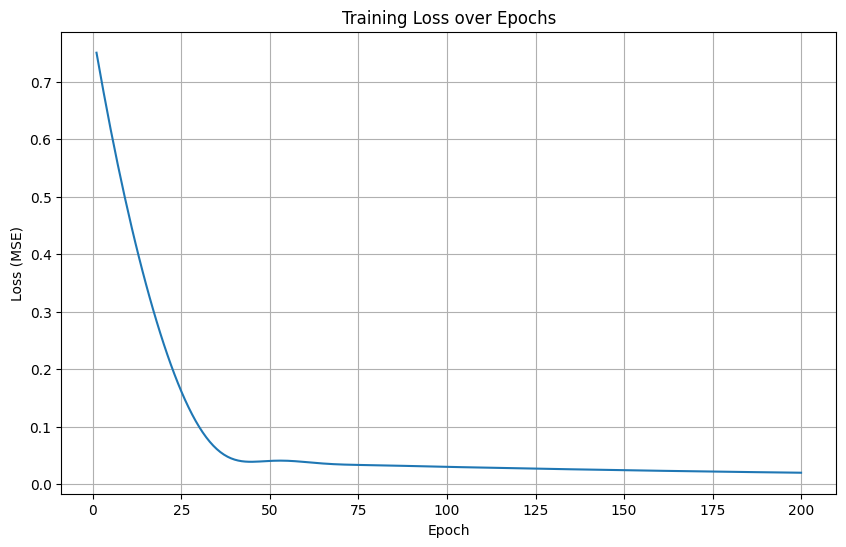

In [15]:
# prompt: Lossの推移を可視化したい

import matplotlib.pyplot as plt
# Training Loop (with loss tracking)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PointUNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 200
loss_history = [] # リストを初期化してlossを保存

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_inputs, batch_targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 1]

        optimizer.zero_grad()
        outputs = model(batch_inputs)             # [B, N, 4]
        loss = criterion(outputs[:, :, 3:], batch_targets)  # 4番目の出力をMSE対象に
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss) # エポックごとの平均lossをリストに追加
    print(f"Epoch {epoch+1} - Loss: {avg_epoch_loss:.6f}")

# Lossの可視化
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


Predicting: 100%|██████████| 1/1 [00:00<00:00, 29.43it/s]



R² Score (Pressure): 0.5999


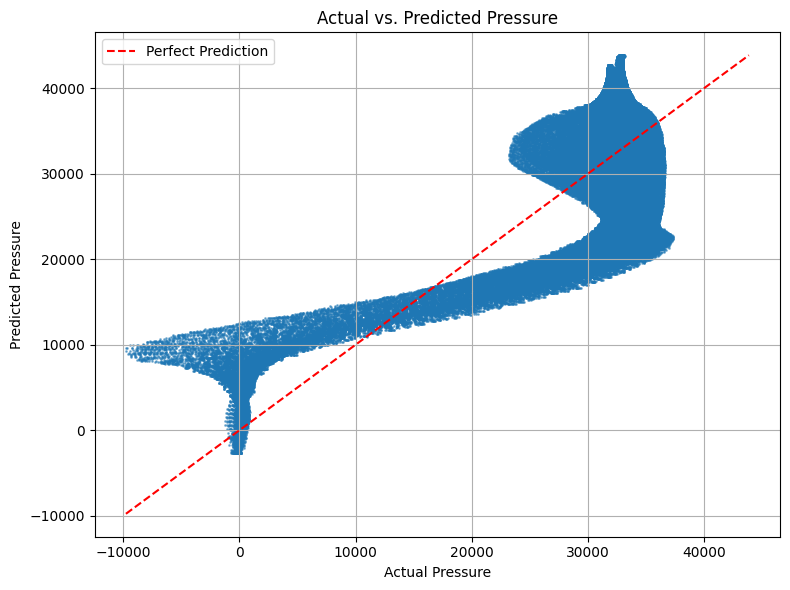

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from tqdm import tqdm
import torch

model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_inputs, batch_targets in tqdm(train_loader, desc="Predicting"):
        batch_inputs = batch_inputs.to(device)    # [B, N, 3]
        batch_targets = batch_targets.to(device)  # [B, N, 1]

        outputs = model(batch_inputs)             # [B, N, 4]
        p_pred = outputs[:, :, 3].cpu().numpy()   # [B, N]
        p_true = batch_targets.squeeze(-1).cpu().numpy()  # [B, N]

        all_predictions.append(p_pred)
        all_targets.append(p_true)

# 結合して評価
predicted_pressure_normalized = np.concatenate(all_predictions, axis=0).flatten()
target_pressure_normalized = np.concatenate(all_targets, axis=0).flatten()

# 元スケールに復元
predicted_pressure_original = train_dataset.inverse_transform(predicted_pressure_normalized)
target_pressure_original = train_dataset.inverse_transform(target_pressure_normalized)

# R²スコア
r2 = r2_score(target_pressure_original, predicted_pressure_original)
print(f"\nR² Score (Pressure): {r2:.4f}")

# 散布図の描画
plt.figure(figsize=(8, 6))
plt.scatter(target_pressure_original, predicted_pressure_original, alpha=0.5, s=1)
plt.xlabel("Actual Pressure")
plt.ylabel("Predicted Pressure")
plt.title("Actual vs. Predicted Pressure")
plt.grid(True)

# 完全一致の赤線
min_val = min(target_pressure_original.min(), predicted_pressure_original.min())
max_val = max(target_pressure_original.max(), predicted_pressure_original.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.tight_layout()
plt.show()


Predicting: 100%|██████████| 1/1 [00:00<00:00, 25.43it/s]


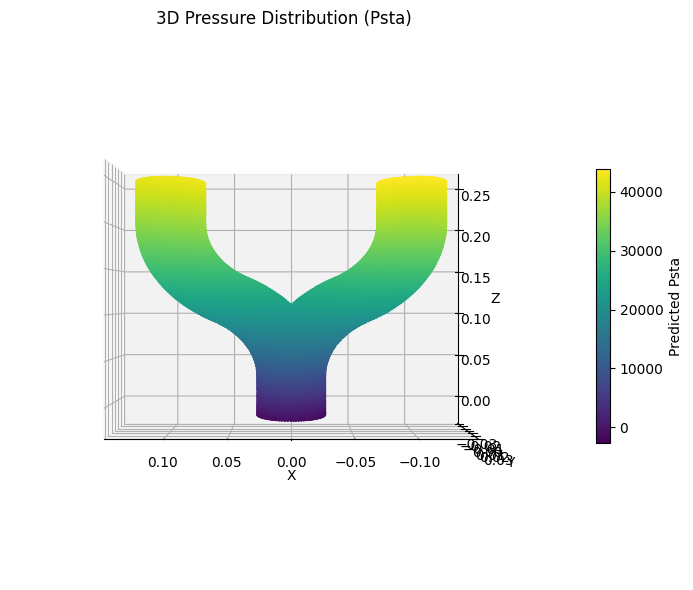

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm
import torch

model.eval()
# ステップ1: モデル出力の収集
all_pred_psta = []  # 推論Psta [B, N]
all_xyz = []        # 座標 [B, N, 3]

model.eval()
with torch.no_grad():
    for batch_inputs, _ in tqdm(train_loader, desc="Predicting"):
        batch_inputs = batch_inputs.to(device)          # [B, N, 3]
        outputs = model(batch_inputs)                   # [B, N, 4]
        p_pred = outputs[:, :, 3].cpu().numpy()         # [B, N]
        xyz = batch_inputs.cpu().numpy()                # [B, N, 3]

        all_pred_psta.append(p_pred.reshape(-1))        # flatten: [B*N]
        all_xyz.append(xyz.reshape(-1, 3))              # flatten: [B*N, 3]

# ステップ2: 結合
psta_norm_flat = np.concatenate(all_pred_psta, axis=0)     # [total_points]
xyz_all = np.concatenate(all_xyz, axis=0)                  # [total_points, 3]

# ステップ3: 正規化解除
psta_original = train_dataset.inverse_transform(psta_norm_flat)  # [total_points]

# ステップ4: 可視化
x, y, z = xyz_all[:, 0], xyz_all[:, 1], xyz_all[:, 2]
assert len(psta_original) == len(x), f"Length mismatch: psta={len(psta_original)}, x={len(x)}"

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta_original, cmap='viridis', s=1)
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Predicted Psta')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Psta)')
ax.view_init(elev=0, azim=90)
plt.tight_layout()
plt.show()


# Individual scalre Training using U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

# --------------------------------------------
# Mish Activation
# --------------------------------------------
def mish(x):
    return x * torch.tanh(F.softplus(x))

# --------------------------------------------
# Kaiming Initialization
# --------------------------------------------
def init_weights_kaiming(module):
    if isinstance(module, nn.Conv1d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

# --------------------------------------------
# Simple PointNet-like U-Net Block for Scalar Output
# --------------------------------------------
class ScalarUNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)

        self.up1 = nn.Conv1d(256 + 128, 128, 1)
        self.up2 = nn.Conv1d(128 + 64, 64, 1)
        self.out = nn.Conv1d(64, 1, 1)

        self.apply(init_weights_kaiming)

    def forward(self, x):
        x = x.transpose(1, 2)  # [B, 3, N]
        x1 = mish(self.conv1(x))
        x2 = mish(self.conv2(x1))
        x3 = mish(self.conv3(x2))

        up1 = mish(self.up1(torch.cat([x3, x2], dim=1)))
        up2 = mish(self.up2(torch.cat([up1, x1], dim=1)))
        out = self.out(up2)  # [B, 1, N]
        return out.transpose(1, 2)  # [B, N, 1]

# --------------------------------------------
# Combined Model with 4 U-Nets and Physics Loss
# --------------------------------------------
class PhysicsInformedCFDModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_u = ScalarUNet()
        self.net_v = ScalarUNet()
        self.net_w = ScalarUNet()
        self.net_p = ScalarUNet()

    def forward(self, coords):
        # coords: [B, N, 3] with requires_grad=True
        u = self.net_u(coords)  # [B, N, 1]
        v = self.net_v(coords)
        w = self.net_w(coords)
        p = self.net_p(coords)
        return u, v, w, p

    def pde_loss(self, coords, u, v, w, p, rho=1.0, mu=1e-3):
        grads_u = grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # [B, N, 3]
        grads_v = grad(v, coords, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        grads_w = grad(w, coords, grad_outputs=torch.ones_like(w), create_graph=True)[0]
        grads_p = grad(p, coords, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        du_dx = grads_u[:, :, 0]
        dv_dy = grads_v[:, :, 1]
        dw_dz = grads_w[:, :, 2]
        continuity = du_dx + dv_dy + dw_dz  # [B, N]
        loss_cont = torch.mean(continuity ** 2)

        # ラプラシアン項
        def laplacian(f, coords):
            grad_f = grad(f, coords, grad_outputs=torch.ones_like(f), create_graph=True)[0]
            lap = 0
            for i in range(3):
                grad2 = grad(grad_f[:, :, i], coords, grad_outputs=torch.ones_like(grad_f[:, :, i]), create_graph=True)[0][:, :, i]
                lap += grad2
            return lap

        # x方向のNS項（例）
        inertia_u = u * grads_u[:, :, 0] + v * grads_u[:, :, 1] + w * grads_u[:, :, 2]  # advective term
        dp_dx = grads_p[:, :, 0]
        lap_u = laplacian(u, coords)
        ns_res_x = rho * inertia_u + dp_dx - mu * lap_u
        loss_ns_x = torch.mean(ns_res_x ** 2)

        # y方向
        inertia_v = u * grads_v[:, :, 0] + v * grads_v[:, :, 1] + w * grads_v[:, :, 2]
        dp_dy = grads_p[:, :, 1]
        lap_v = laplacian(v, coords)
        ns_res_y = rho * inertia_v + dp_dy - mu * lap_v
        loss_ns_y = torch.mean(ns_res_y ** 2)

        # z方向
        inertia_w = u * grads_w[:, :, 0] + v * grads_w[:, :, 1] + w * grads_w[:, :, 2]
        dp_dz = grads_p[:, :, 2]
        lap_w = laplacian(w, coords)
        ns_res_z = rho * inertia_w + dp_dz - mu * lap_w
        loss_ns_z = torch.mean(ns_res_z ** 2)

        loss_ns = loss_ns_x + loss_ns_y + loss_ns_z
        return loss_cont, loss_ns
